# **A Deep Learning Approach for Intrusion Detection Using Recurrent Neural Networks**



> Multiclass-5 classes(4 Attack and Normal), KDDTest_21



In [ ]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random

In [ ]:
## add the columns' name and read the KDDTrain+ and KDDTest+ datasets
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

#Training set
df = pd.read_csv("NSL_KDD_Train.csv",header=None, names = col_names)
# Testing set
df_test_21 = pd.read_csv("NSL_KDD_Test_21.csv", header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test_21 set:',df_test_21.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test_21 set: (11850, 42)


In [ ]:
# review the features type
df.head(5) 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
print('Label distribution in the Training set:')
print("****************************************")
print(df['label'].value_counts())
print('\n')
print('Label distribution in the Test set:')
print("**************************************")
print(df_test_21['label'].value_counts())

Label distribution in the Training set:
****************************************
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


Label distribution in the Test set:
**************************************
normal             2152
neptune            1579
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               727
processtable        685
smurf               627
back                359
s

# **Step 1: Data preprocessing:**

One-Hot-Encoding is used to convert all categorical properties to binary properties. One-Hot-Endcoding requirement, the input to this transformer must be an integer matrix expressing values taken with categorical (discrete) properties. The output will be a sparse matrix in which each column corresponds to a possible value. It is assumed that the input properties have values in the range [0, n_values]. Therefore, to convert each category to a number, properties must first be converted with LabelEncoder.

In [ ]:
# columns are categorical, not yet binary: protocol_type (column 2), service (column 3), flag (column 4).
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
# Test set
print('Test set:')
for col_name in df_test_21.columns:
    if df_test_21[col_name].dtypes == 'object' :
        unique_cat = len(df_test_21[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 62 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


**LabelEncoder**

**Insert categorical features into a 2D numpy array**

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
# for Test
testdf_categorical_values = df_test_21[categorical_columns]

In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test_21.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

**Transform categorical features into numbers using LabelEncoder()**

In [ ]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


**One-Hot-Encoding**

In [ ]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

Missing columns in test set are added 




In [ ]:
trainservice=df['service'].tolist()
testservice= df_test_21['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(11850, 84)


New numeric columns are added to main dataframe

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test_21.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(11850, 123)


**Feature Scaling**

In [ ]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
newdf['log2_value1'] = np.log2(newdf['duration'])
newdf['log2_value2'] = np.log(newdf['src_bytes'])
newdf['log2_value3'] = np.log(newdf['dst_bytes'])
newdf=newdf.drop(['log2_value3','log2_value2','log2_value1'], axis=1)


# testing set

newdf_test['log2_value1'] = np.log2(newdf_test['duration'])
newdf_test['log2_value2'] = np.log(newdf_test['src_bytes'])
newdf_test['log2_value3'] = np.log(newdf_test['dst_bytes'])
newdf_test=newdf_test.drop(['log2_value3','log2_value2','log2_value1'], axis=1)

print(newdf)
print(newdf_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0        491          0     0               0       0    0   
1              0        146          0     0               0       0    0   
2              0          0          0     0               0       0    0   
3              0        232       8153     0               0       0    0   
4              0        199        420     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
125968         0          0          0     0               0       0    0   
125969         8        105        145     0               0       0    0   
125970         0       2231        384     0               0       0    0   
125971         0          0          0     0               0       0    0   
125972         0        151          0     0               0       0    0   

        num_failed_logins  logged_in  num_compromised  ...  flag_REJ  \
0  

The dataset was divided into separate datasets for each attack category. Attack tags have been renamed for each. 0 = Normal, 1 = DoS, 2 = Probe, 3 = R2L, 4 = U2R. In the new datasets, the tag column has been replaced with the new values.

In [ ]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                            'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



#put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [ ]:
#Split the test and train data into training and testing 
# train set:
x=newdf.drop(["label"],1)  # features
y=newlabeldf  # label
# test set:
xtest=newdf_test.drop(['label'],1) # features
ytest=newlabeldf_test # label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# **RNN Model**

In [ ]:
# multi-class classification
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(80, input_dim=122, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
  
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator,xtest,ytest, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Accuracy: 88.40%


In [ ]:
# Step 2: the value of every feature is mapped to the [0,1] range linearly
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
# Training Set
scale = MinMaxScaler()
scale = preprocessing.StandardScaler().fit(x)
x=scale.transform(x)
scaletest = preprocessing.StandardScaler().fit(xtest)
xtest=scaletest.transform(xtest)

In [ ]:
to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

# Filter all rows with label value except itself
# isin filter function

DoS_df=newdf[newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[newdf['label'].isin(to_drop_U2R)];



#test
DoS_df_test=newdf_test[newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[newdf_test['label'].isin(to_drop_U2R)];


print('Train Set:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print()
print('Test Set:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train Set:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)

Test Set:
Dimensions of DoS: (6496, 123)
Dimensions of Probe: (4554, 123)
Dimensions of R2L: (5037, 123)
Dimensions of U2R: (2219, 123)


**`Split the training set and testing set`**

In [ ]:
# Split dataframes into X & Y
# X Properties, Y result variable

X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label

X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label

X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label

X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label

# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label

X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label

X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label

X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future v

**Since the column names will be deleted at this stage, we save the column names for later use.**

In [ ]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

**Step 2: Feature Scaling**

In [ ]:
from sklearn import preprocessing

scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 

scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe)

scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L)

scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 

# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 

scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 

scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 

scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

**Build the Compartive Machine learning Models:**

**DoS**

DoS
     Accuracy Score
MLP        0.724908
SVM        0.624692
NB         0.596059
J48        0.561730
RF         0.372691




Text(0.5, 0, 'DoS')

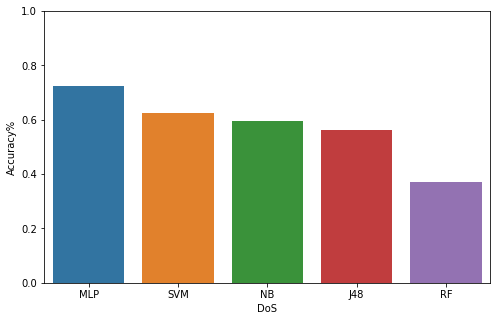

In [ ]:
#1. DoS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt 
import seaborn as sns

mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model = value
    model.fit(X_DoS, Y_DoS.astype(int))
    scores[key] = model.score(X_DoS_test , Y_DoS_test)

# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('DoS')
print(scores_frame)
print("\n")

plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("DoS")

**Probe**

Probe
     Accuracy Score
RF         0.641195
MLP        0.624286
J48        0.528766
SVM        0.464646
NB         0.410848




Text(0.5, 0, 'Probe')

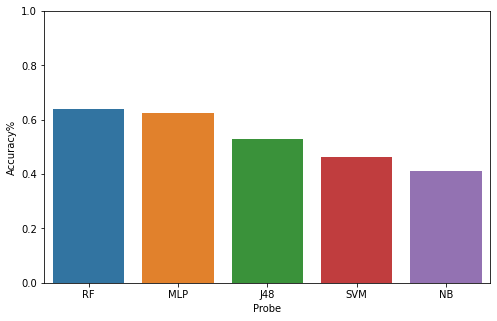

In [ ]:
# 2.Probe
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model1 = value
    model1.fit(X_Probe, Y_Probe.astype(int))
    scores[key] = model1.score(X_Probe_test , Y_Probe_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('Probe')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("Probe")

**R2L**

R2L
     Accuracy Score
MLP        0.430018
J48        0.427635
NB         0.427238
RF         0.427238
SVM        0.427238




Text(0.5, 0, 'R2L')

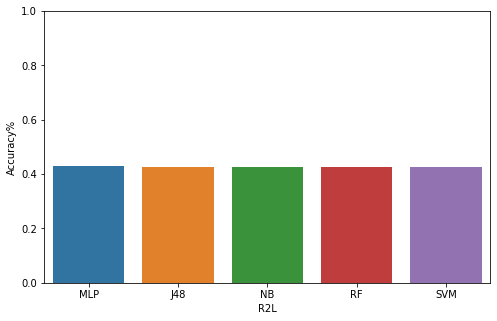

In [ ]:
# 3.R2L
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model2 = value
    model2.fit(X_R2L, Y_R2L.astype(int))
    scores[key] = model2.score(X_R2L_test , Y_R2L_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('R2L')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("R2L")

**U2R**

U2R
     Accuracy Score
J48        0.969806
NB         0.969806
RF         0.969806
SVM        0.969806
MLP        0.969356




Text(0.5, 0, 'U2R')

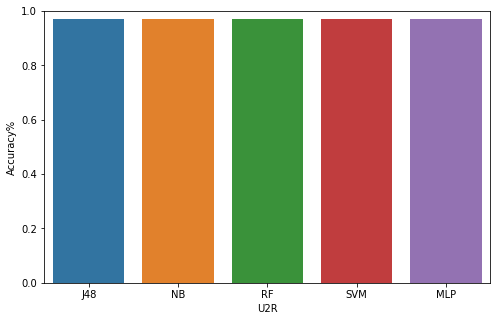

In [ ]:
# 4.U2R
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model3 = value
    model3.fit(X_U2R, Y_U2R.astype(int))
    scores[key] = model3.score(X_U2R_test , Y_U2R_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('U2R')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame['Accuracy Score'])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("U2R")

**Step 5: Prediction & Evaluation (validation):**

In [ ]:
# 1.DoS
Y_DoS_pred=model.predict(X_DoS_test)
# Create confusion matrix
print('Dos')
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Dos


Predicted attacks,0,1
Actual attacks,,
0,2052,100
1,2338,2006


In [ ]:
#2.Probe
Y_Probe_pred=model1.predict(X_Probe_test)

# Create confusion matrix
print('Probe')
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Probe


Predicted attacks,0,2
Actual attacks,,
0,2061,91
2,2347,55


In [ ]:
#3.R2L
Y_R2L_pred=model2.predict(X_R2L_test)
# Create confusion matrix
print('R2L')
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

R2L


Predicted attacks,0
Actual attacks,
0,2152
3,2885


In [ ]:
#4.U2R
Y_U2R_pred=model3.predict(X_U2R_test)
print('U2R')
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

U2R


Predicted attacks,0
Actual attacks,
0,2152
4,67
